In [16]:
import os
import json
import torch
from PIL import Image
from torchvision.transforms import functional as F

# Define device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


class TissueMicroarrayDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "augmented_images"))))
        self.labels = list(sorted(os.listdir(os.path.join(root, "augmented_labels"))))

    def __getitem__(self, idx):
        # Load images
        img_path = os.path.join(self.root, "augmented_images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        
        # Load labels
        label_path = os.path.join(self.root, "augmented_labels", self.labels[idx])
        with open(label_path) as f:
            annotations = json.load(f)

        # Convert circles to bounding boxes
        boxes = []
        for ann in annotations:
            x = ann['x']
            y = ann['y']
            radius = ann['radius']
            boxes.append([x - radius, y - radius, x + radius, y + radius])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((len(boxes),), dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Apply the transformations
        if self.transforms is not None:
            img = self.transforms(img)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target  # Convert the PIL Image to a PyTorch tensor

    def __len__(self):
        return len(self.imgs)

import os
import json
import torch
import torchvision
from PIL import Image
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD
import torch.nn as nn
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork

def get_model_instance_segmentation(num_classes):
    fasterRCNN = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Define RPN 
    anchor_generator = AnchorGenerator(sizes=tuple([(16, 32, 48, 64, 72) for _ in range(5)]), # let num of tuple equal to num of feature maps
                                aspect_ratios=tuple([(0.25, 0.5, 0.75, 1, 1.25, 1.5) for _ in range(5)])) # ref: https://github.com/pytorch/vision/issues/978
    rpn_head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])
    fasterRCNN.rpn = RegionProposalNetwork(
        anchor_generator= anchor_generator, head= rpn_head,
        fg_iou_thresh= 0.3, bg_iou_thresh=0.1,
        batch_size_per_image=1024,
        positive_fraction = 0.5,
        pre_nms_top_n=dict(training=4000, testing=2000),
        post_nms_top_n=dict(training=2000, testing=1000),
        nms_thresh = 0.3
    )
    in_features = fasterRCNN.roi_heads.box_predictor.cls_score.in_features #get number of features
    fasterRCNN.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes = num_classes)
    fasterRCNN.roi_heads.fg_bg_sampler.batch_size_per_image = 512
    fasterRCNN.roi_heads.fg_bg_sampler.positive_fraction = 0.5
    return fasterRCNN


def save_checkpoint(state, filename="checkpoint.pth.tar"):
    torch.save(state, filename)

import torch.nn.functional as F

def classification_loss(pred_logits, true_labels):
    # Assuming pred_logits are raw scores and true_labels are the ground-truth labels
    return F.cross_entropy(pred_logits, true_labels)

def bbox_regression_loss(pred_bboxes, true_bboxes):
    # Assuming both pred_bboxes and true_bboxes are in the same format
    return F.smooth_l1_loss(pred_bboxes, true_bboxes)

# Training function
def train_model(model, data_loader_train, optimizer, scheduler, device, num_epochs, checkpoint_path=None):
    best_loss = float('inf')
    start_epoch = 0

    # Load from checkpoint if it exists
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_loss = checkpoint.get('loss', best_loss)
        print(f"Loaded checkpoint from epoch {start_epoch} with training loss {best_loss}")

    model.to(device)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0

        for images, targets in data_loader_train:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_loss += losses.item()

        epoch_loss = running_loss / len(data_loader_train)
        
        # Step the scheduler with the epoch loss
        scheduler.step(epoch_loss)

        # Save the model if the loss has decreased
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            save_checkpoint({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
            }, filename=f"best_model.pth.tar")
            print(f"Checkpoint saved at epoch {epoch + 1} with training loss {best_loss}")

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss}")

    print("Training complete")


# Testing function
def test_model(model, data_loader, device):
    model.to(device)
    model.eval()
    results = []
    with torch.no_grad():
        for images, _ in data_loader:
            images = list(image.to(device) for image in images)
            predictions = model(images)
            results.extend(predictions)
    return results

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(image.to(device) for image in images)
    images = torch.stack(images, dim=0)
    
    new_targets = []
    for t in targets:
        # Remove the extra dimension you might have added during padding.
        # The boxes should be a 2D tensor with shape [N, 4].
        boxes = t['boxes'].squeeze(0)
        new_target = {k: v if k != 'boxes' else boxes for k, v in t.items()}
        new_targets.append(new_target)
    
    return images, new_targets



In [3]:

# Set the proper root directory for your dataset
dataset_root = './'

# Use the dataset and defined transformations for training and validation sets
dataset_train = TissueMicroarrayDataset(dataset_root, transforms=ToTensor())
dataset_val = TissueMicroarrayDataset(dataset_root, transforms=ToTensor())
# Split the dataset into train and validation sets, you may want to implement a proper split
train_size = int(0.8 * len(dataset_train))
val_size = len(dataset_train) - train_size
dataset_train, dataset_val = torch.utils.data.random_split(dataset_train, [train_size, val_size])


# Then use this function in your DataLoader
data_loader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)


In [13]:

# Get the model
model = get_model_instance_segmentation(num_classes=2)

from torch.optim.lr_scheduler import ReduceLROnPlateau

model.to(device)
optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

# Number of training epochs
num_epochs = 100

# Train the model 
train_model(model, data_loader_train, optimizer, scheduler, device, num_epochs=num_epochs, checkpoint_path="best_model_batch_size_inc.pth.tar")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Checkpoint saved at epoch 1 with training loss 1.4657169298121804
Epoch 1/100, Training Loss: 1.4657169298121804
Checkpoint saved at epoch 2 with training loss 0.8361159014074426
Epoch 2/100, Training Loss: 0.8361159014074426


KeyboardInterrupt: 

In [6]:

# Define the model

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
import torch


# model = get_model_instance_segmentation(num_classes=2)
# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the model checkpoint
checkpoint_path = "./best_model.pth.tar"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Load the saved weights into the model
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the right device
model.to(device)



In [14]:

# Evaluate the model on the validation set
results = test_model(model, data_loader_val, device)
# Process results, e.g., calculate model accuracy


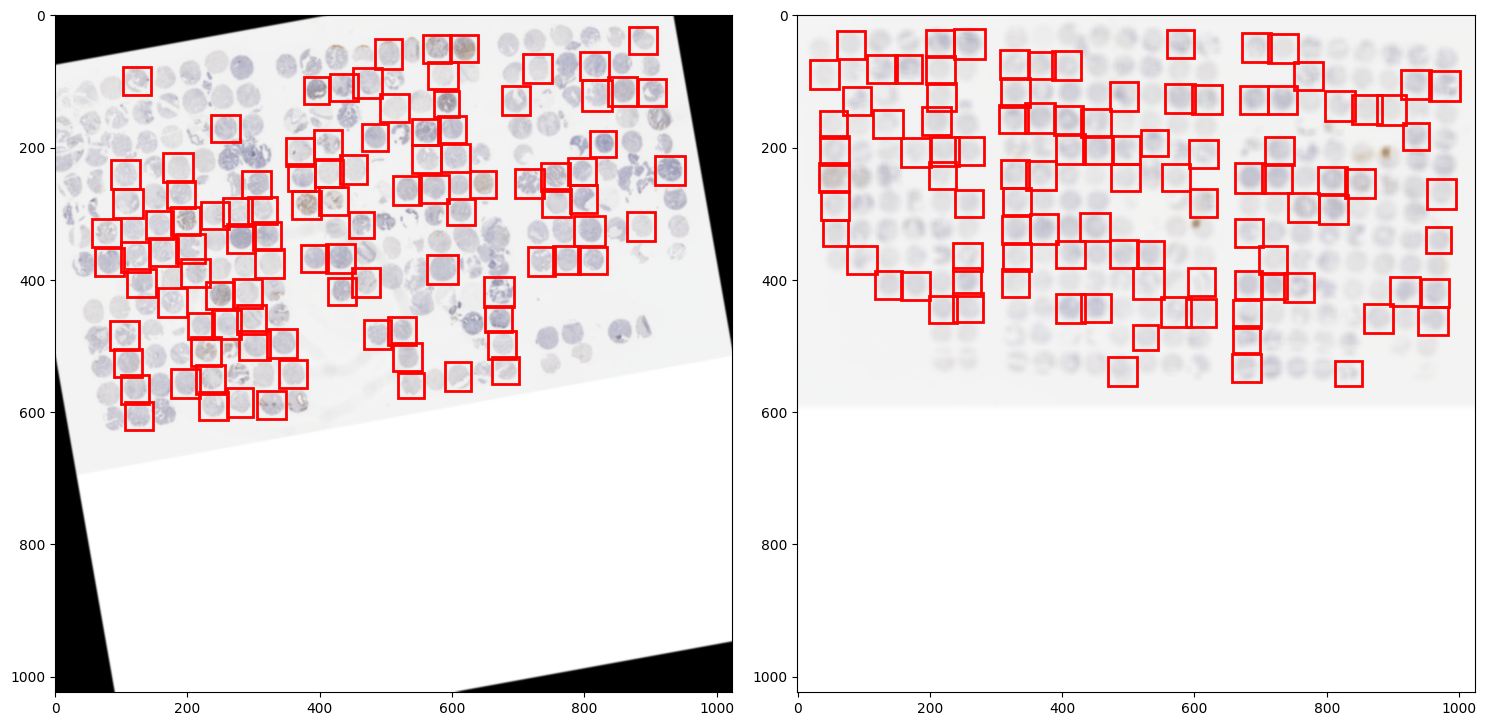

In [15]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

def visualize_predictions_in_grid(image_indices, dataset, predictions, confidence_threshold=0.5, grid_dims=(2, 5)):
    # Calculate the number of rows and columns for the grid
    rows, cols = grid_dims

    # Create a figure with subplots in a grid layout
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))  # Adjust the figure size as needed
    axes = axes.ravel()  # Flatten the 2D array of axes

    for i, ax in zip(image_indices, axes):
        image, _ = dataset[i]  # Get an image from the dataset
        prediction = predictions[i]  # Get the corresponding prediction

        # Visualization code here, using ax as the subplot axis
        image = image.cpu().numpy().transpose(1, 2, 0)
        ax.imshow(image)

        # Filter out boxes below the confidence threshold
        above_threshold = prediction['scores'] > confidence_threshold

        for box, label, score in zip(prediction["boxes"][above_threshold], prediction["labels"][above_threshold], prediction["scores"][above_threshold]):
            box = box.cpu().numpy()
            x, y, xmax, ymax = box
            width, height = xmax - x, ymax - y
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

    # Hide unused subplots
    for ax in axes[len(image_indices):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_indices = range(13,15)  # The indices of images you want to plot
visualize_predictions_in_grid(image_indices, dataset_val, results, confidence_threshold=0.75, grid_dims=(1, 2))

